# Proyecto Final: Estadística Aplicada III. Análisis de componentes principales (PCA) para compresión de imágenes

Equipo:
* Mariana Luna Rocha (000195548) 
*  Mauricio Vázquez Moran (000191686)

## Contenido del Notebook

* I. Librerias 
* II. Introducción
* III. Exploración de una imagen
* IV. Reduciendo dimensionalidad con PCA

## I. Librerias

In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.ndimage import sobel
import warnings
from sklearn.decomposition import PCA, IncrementalPCA

# Configuracion librerias
warnings.filterwarnings('ignore')

## II. Introducción


El análisis de componentes principales es una técnica utilizada en estadística y machine learning para **reducir la dimensionalidad** de conjuntos de datos con un alto número de variables. Al identificar las direcciones principales donde se encuentra la mayor variabilidad, PCA permite simplificar los datos manteniendo la información más relevante. En pocas palabras, el objetivo principal del PCA es resumir un conjunto de variables en un número menor de variables significativas que, colectivamente, expliquen la mayor parte de la variabilidad presente en el conjunto original de datos (An Introduction to Statistical Learning, James et al. 2017). Esta técnica es particularmente útil en problemas relacionados con imágenes, donde las dimensiones suelen ser muy altas debido al gran número de píxeles. 

En este notebook, exploraremos cómo PCA puede ser aplicado a la compresión de imágenes, un proceso que busca representar una imagen en un espacio de menor dimensión mientras se conserva su esencia visual. Esto no solo reduce el tamaño del archivo, sino que también puede facilitar el procesamiento en tareas computacionalmente intensivas como el entrenamiento de modelos de machine learning. Dicho esto, la compresión de imágenes mediante *PCA* se basa en:

1. Identificar componentes principales que expliquen la mayor parte de la variabilidad en los valores de los píxeles.
2. Reducir la dimensionalidad utilizando únicamente un subconjunto de estos componentes principales.
3. Reconstruir la imagen a partir de los componentes seleccionados, comparando la calidad visual con la imagen original.

<p align="center">
  <img src="pca_image.png" width="600" heigth="600">
</p>

***Método***

1. Se carga la imagen como matriz.
2. Hay que dividir, por ejemplo, la imagen en 400 bloques de 10 por 10 píxeles, de modo que el primer bloque contenga píxeles en las filas 1-10, columnas 1-10, el segundo bloque contenga píxeles en las filas 1-10, columnas 11-20, y así sucesivamente. Cada bloque contiene 100 valores de píxeles y puede considerarse como un vector de entrada de 100 dimensiones; en total tienes 400 vectores de entrada de 100 dimensiones.
3. Calcular el primer componente PCA de este conjunto de datos (400 elementos, 100 características) y proyectar cada vector de entrada sobre ese componente — el resultado es un valor escalar por vector de entrada.
4. Se proyectan los valores escalares de vuelta como una reconstrucción de las características originales, el resultado es un vector de 100 dimensiones por vector de entrada. Se dibuja la imagen resultante: para cada bloque de píxeles, en lugar de los valores de píxeles originales, dibujar los valores aproximados.
5. Se realiza el mismo procedimiento para 2 componentes, 5, 10, 20 y 30 componentes PCA.

## III. Exploración de una imagen de nuestro conjunto de imagenes

En esta sección, introduciremos el concepto de imágenes como matrices numéricas y exploraremos cómo trabajar con ellas en Python. Las imágenes son representaciones en forma de matrices, donde cada elemento de la matriz representa el valor de un píxel. En el caso de imágenes en color, estas matrices suelen tener tres dimensiones:

 - Altura: Número de píxeles verticales.
 - Anchura: Número de píxeles horizontales.
 - Canales de color (RGB): Tres matrices asociadas a los colores rojo, verde y azul.

Usaremos bibliotecas populares como *matplotlib* y *numpy* para cargar y visualizar una imagen. El proceso incluye:

- Cargar la imagen en formato matricial utilizando imread.
- Verificar las dimensiones de la matriz resultante.
- Visualizar la imagen en su forma original.

Por otro lado, podemos visualizar el histograma de los pixeles de la imagen:

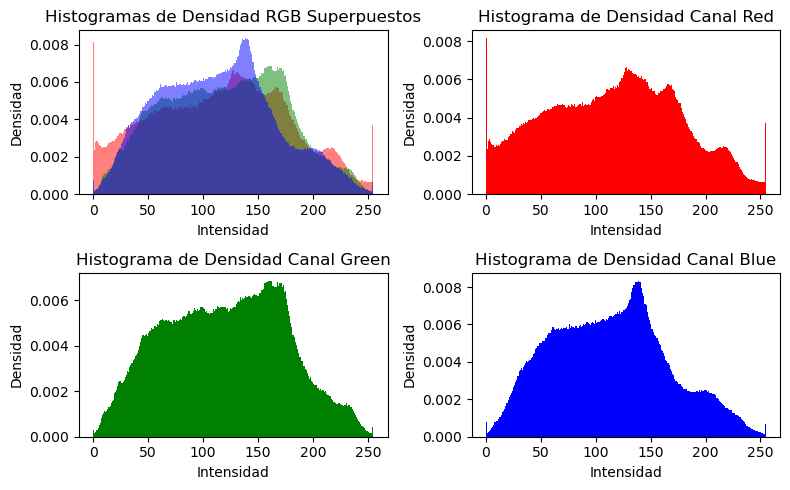

In [2]:
# Visualización de histograma para cada canal (Rojo, Verde, Azul)
image_raw = imread("IMAGES\my_dogs5.jpeg")
fig, axs = plt.subplots(2, 2, figsize=(8, 5))
axs = axs.ravel()

# Subplot 1: Todos los histogramas juntos
colors = ('Red', 'Green', 'Blue')
for i, color in enumerate(colors):
    axs[0].hist(image_raw[:, :, i].ravel(), bins=256, color=color.lower(), alpha=0.5, density=True)
axs[0].set_title("Histogramas de Densidad RGB Superpuestos")
axs[0].set_xlabel("Intensidad")
axs[0].set_ylabel("Densidad")

# Subplots individuales para cada canal
for i, color in enumerate(colors):
    axs[i+1].hist(image_raw[:, :, i].ravel(), bins=256, color=color.lower(), density=True)
    axs[i+1].set_title(f"Histograma de Densidad Canal {color}")
    axs[i+1].set_xlabel("Intensidad")
    axs[i+1].set_ylabel("Densidad")

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

***Observaciones:***

1. Histograma RGB Superpuesto:

   - Se observa una mayor concentración de intensidades entre 100-200.

2. Canal Rojo:

   - Muestra un pico pronunciado alrededor de 150.
   - Tiene una distribución amplia entre 50-200.
   - Indica presencia significativa de tonos medios en rojo.
   - Hay pocos valores extremos (muy claros o muy oscuros).

3. Canal Verde:

   - Distribución más uniforme que los otros canales.
   - Mayor presencia en intensidades medias (100-175).
   - Sugiere una buena distribución de tonos verdes en la imagen.
   - La forma es más plana, indicando variedad en los tonos verdes.

4. Canal Azul:

   - Pico pronunciado alrededor de 150-175.
   - Distribución sesgada hacia intensidades medias-altas.
   - Menor presencia en intensidades bajas.
   - Sugiere predominancia de tonos azules medios-claros.

Para simplificar el análisis y reducir la dimensionalidad desde el principio, transformaremos la imagen de color (RGB) a escala de grises. Esto mencionado se hace combinando los valores de los canales de color en una única matriz bidimensional, donde cada valor representa la intensidad de un píxel (de 0 a 1):

 - 0 : Blanco (máxima intensidad).
 - 1 : Negro (mínima intensidad).

El proceso de conversión incluye:
1. Sumar los valores de los canales RGB para obtener un único valor de intensidad por píxel.
2. Normalizar los valores de la matriz para asegurarse de que estén en el rango de 0 a 1.

Dimensiones de la imagen original: alto de 1600 pixeles, ancho de 1200 pixeles y 3 canales de color (RGB).
Dimensiones de la imagen transformada: alto de 1600 pixeles y ancho de 1200 pixeles.


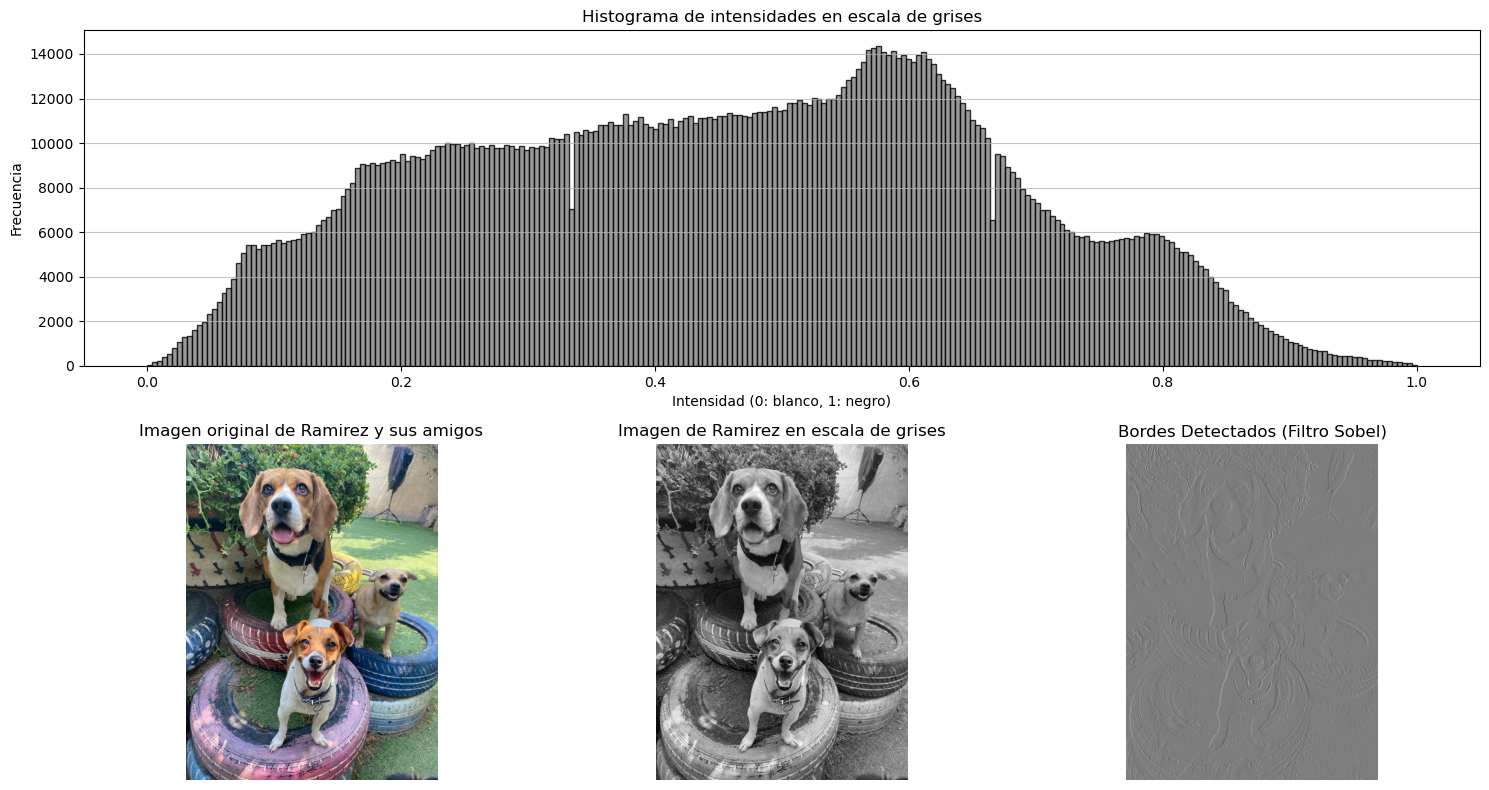

In [3]:
# Cargar y mostrar la imagen original
image_raw = imread("IMAGES\my_dogs5.jpeg")

# Convertir a escala de grises
image_sum = image_raw.sum(axis=2)  
image_bw = image_sum / image_sum.max()  

# Imprimir las dimensiones 
print(f"Dimensiones de la imagen original: alto de {image_raw.shape[0]} pixeles, ancho de {image_raw.shape[1]} pixeles y {image_raw.shape[2]} canales de color (RGB).")
print(f"Dimensiones de la imagen transformada: alto de {image_bw.shape[0]} pixeles y ancho de {image_bw.shape[1]} pixeles.")

# Detectar bordes con el filtro de Sobel
sobel_edges = sobel(image_bw)

# Crear una figura con dos filas
fig = plt.figure(figsize=(15, 8))

# Primera fila: Histograma de intensidades en escala de grises
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax1.hist(image_bw.ravel(), bins=256, color='gray', alpha=0.8, edgecolor='black')
ax1.set_title("Histograma de intensidades en escala de grises")
ax1.set_xlabel("Intensidad (0: blanco, 1: negro)")
ax1.set_ylabel("Frecuencia")
ax1.grid(axis='y', alpha=0.75)

# Segunda fila columna 1: imagen original
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax2.imshow(image_raw)
ax2.set_title("Imagen original de Ramirez y sus amigos")
ax2.axis('off')

# Segunda fila columna 2: imagen en escala de grises
ax3 = plt.subplot2grid((2, 3), (1, 1))
ax3.imshow(image_bw, cmap='gray')
ax3.set_title("Imagen de Ramirez en escala de grises")
ax3.axis('off')

# Segunda fila columna 3: filtro de bordes
ax4 = plt.subplot2grid((2, 3), (1, 2))
ax4.imshow(sobel_edges, cmap='gray')
ax4.set_title("Bordes Detectados (Filtro Sobel)")
ax4.axis('off')

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

Por otro lado, tenemos las algunas de las estadísticas descriptivas de la imagen:

In [4]:
# Estadísticas descriptivas
mean_intensity = np.mean(image_bw)
median_intensity = np.median(image_bw)
std_intensity = np.std(image_bw)
min_intensity = np.min(image_bw)
max_intensity = np.max(image_bw)

print(f"Promedio de intensidad: {mean_intensity:.4f}")
print(f"Mediana de intensidad: {median_intensity:.4f}")
print(f"Desviación estándar: {std_intensity:.4f}")
print(f"Intensidad mínima: {min_intensity:.4f}")
print(f"Intensidad máxima: {max_intensity:.4f}")

Promedio de intensidad: 0.4575
Mediana de intensidad: 0.4654
Desviación estándar: 0.2087
Intensidad mínima: 0.0000
Intensidad máxima: 1.0000


In [5]:
# Dividir la imagen en 4 cuadrantes
h, w = image_bw.shape
quadrants = {
    "Superior izquierda": image_bw[:h//2, :w//2],
    "Superior derecha": image_bw[:h//2, w//2:],
    "Inferior izquierda": image_bw[h//2:, :w//2],
    "Inferior derecha": image_bw[h//2:, w//2:]
}

# Calcular estadísticas para cada cuadrante
for name, quadrant in quadrants.items():
    print(f"{name}: Promedio = {np.mean(quadrant):.4f}, Desviación Estándar = {np.std(quadrant):.4f}")

Superior izquierda: Promedio = 0.3804, Desviación Estándar = 0.2096
Superior derecha: Promedio = 0.5329, Desviación Estándar = 0.1874
Inferior izquierda: Promedio = 0.4432, Desviación Estándar = 0.2135
Inferior derecha: Promedio = 0.4735, Desviación Estándar = 0.1937


1. Superior izquierda:
Esta región corresponde a la cara del perrito del lado izquierdo. La variabilidad moderada sugiere que incluye tanto tonos claros (el pelaje) como oscuros (la nariz y los ojos), resultando en un promedio intermedio de intensidad.

2. Superior derecha:
Esta región incluye partes más oscuras del fondo. El bajo promedio y la baja variabilidad reflejan que aquí predominan tonos oscuros y uniformes.

3. Inferior izquierda:
Esta región incluye más detalles del cuerpo del perrito izquierdo, como el pelaje más claro, lo que explica el promedio de intensidad más alto y una menor variabilidad.

4. Inferior derecha:
Representa el área correspondiente al perrito derecho, que tiene tonos moderados y ligeramente más uniformes, lo que justifica el promedio y la desviación estándar observados.

## IV. Reduciendo dimensionalidad con PCA

En primer lugar, hagamos un pequeño analisisd de la cantidad de componentes principales que preservan el 95% de la varianza. Esto nos ayudara a tener una noción  sobre que componente podriamos eliminar debido a que aportan poco. De igual manera, nos muestra cuánta información podemos conservar con menos dimensiones, permite visualizar la eficiencia de la reducción dimensional y ayuda a justificar decisiones sobre el nivel de compresión,

Número de componentes que explican el 95% de la varianza: 131


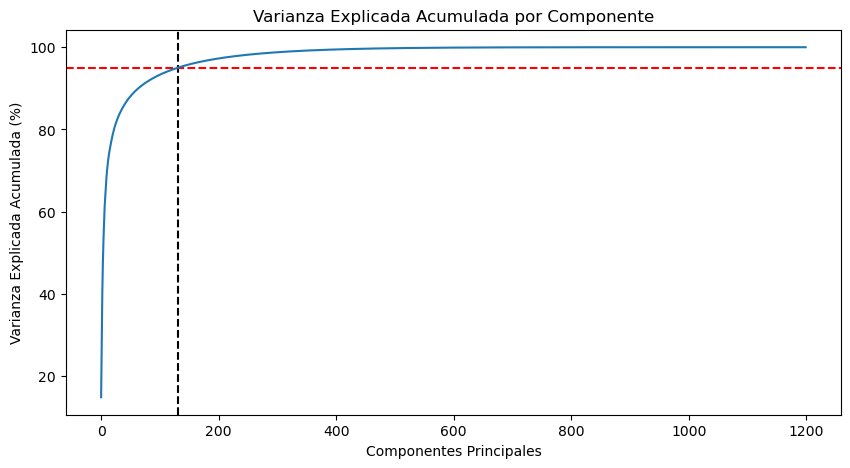

In [ ]:
# 1. Crear y ajustar el modelo PCA
pca = PCA()  # Inicializar PCA sin especificar número de componentes
pca.fit(image_bw)  # Ajustar PCA a la imagen en escala de grises

# 2. Calcular la varianza acumulada explicada
var_cumu = np.cumsum(pca.explained_variance_ratio_) * 100

# 3. Encontrar cuántos componentes explican el 95% de la varianza
k = np.argmax(var_cumu > 95)
print(f"Número de componentes que explican el 95% de la varianza: {k}")

# Visualización elbow-plot
plt.figure(figsize=[10, 5])
plt.title('Varianza Explicada Acumulada por Componente')
plt.ylabel('Varianza Explicada Acumulada (%)')
plt.xlabel('Componentes Principales')
plt.axvline(x=k, color="k", linestyle="--")  
plt.axhline(y=95, color="r", linestyle="--")

# Graficar la varianza acumulada
ax = plt.plot(var_cumu)

***Observaciones:***

1. Comportamiento de la curva:

    - La curva muestra un crecimiento muy pronunciado al inicio (0-180 componentes aproximadamente).
    - Luego se aplana significativamente después de aproximadamente 180 componentes (marcado por la línea vertical punteada negra).
    - Después de este punto, añadir más componentes aporta muy poca varianza explicada adicional.

2. Interpretación del 95% de varianza (línea roja punteada):

    - La línea horizontal roja marca el umbral del 95% de varianza explicada y se alcanza este umbral aproximadamente en los 180 componentes aproximadamente.
    - Esto significa que podemos representar el 95% de la información de la imagen usando solo ~180 componentes principales.

1. Eficiencia de la reducción:

    - La imagen original probablemente tiene muchas más dimensiones (>1200 componentes como se ve en el eje x).
    - Esto representa una reducción significativa en la dimensionalidad mientras se mantiene la mayoría de la información relevante.

4. Implicaciones prácticas:

    - Sería eficiente usar ~200 componentes para reconstruir la imagen.
    - Usar menos componentes podría resultar en una pérdida significativa de información.

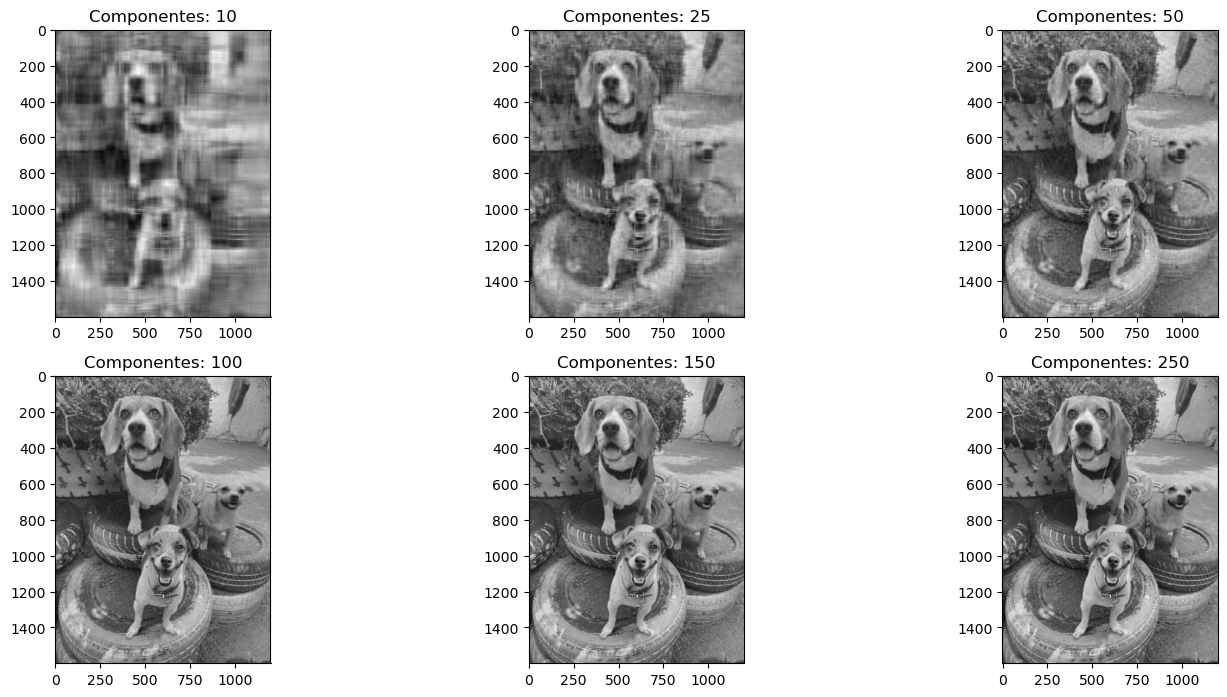

In [12]:
# Funcion auxiliar para visualizar
def plot_at_k(k):
    # Creando un modelo PCA con k componentes
    ipca = IncrementalPCA(n_components=k)
    
    # Ajustar y transformar la imagen (reducción de dimensionalidad)
    # y luego reconstruirla con inverse_transform
    image_recon = ipca.inverse_transform(ipca.fit_transform(image_bw))
    
    # Mostrar la imagen reconstruida en escala de grises
    plt.imshow(image_recon, cmap=plt.cm.gray)

# Definiendo la lista de diferentes números de componentes a probar
ks = [10, 25, 50, 100, 150, 250]

plt.figure(figsize=[15,9])

# For-loop para iterar
for i in range(6):
    plt.subplot(2,3,i+1)  
    plot_at_k(ks[i])      
    plt.title("Componentes: "+str(ks[i]))

# Espaciado entre subplots
plt.subplots_adjust(wspace=1.2, hspace=0.0)
plt.show()